# Data ingestion:


### Firstly an initial landing table is created for the data, also an INTERNAL NAMED STAGE so the data can be uploaded.
#### This process was handled using SNOWSQL.

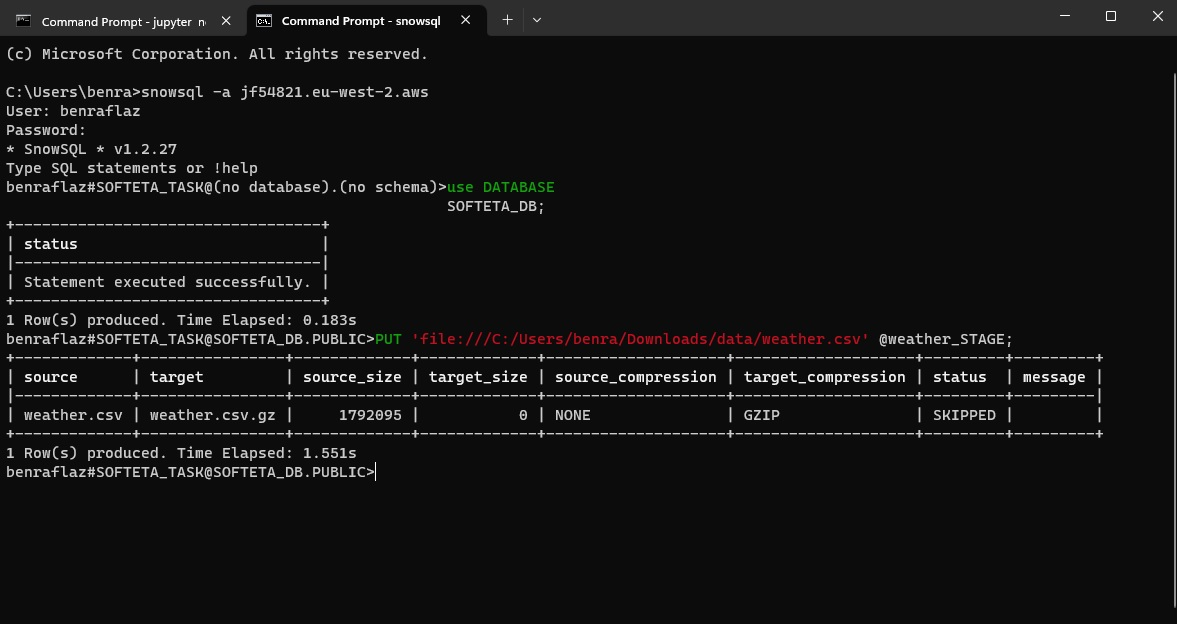

### The code used to create the table, stage and uploading/copying the data. The STAGE is then dropped since it counts towards your storage/credits.

In [ ]:
USE DATABASE softeta_db;
USE SCHEMA public;

CREATE TABLE weather(
rain_precipitation FLOAT,
date_full VARCHAR,
date_month INT,
date_week INT,
date_year INT,
station_city VARCHAR,
station_code VARCHAR,
station_location VARCHAR,
station_state VARCHAR,
avg_temp INT,
max_temp INT,
min_temp INT,
wind_direction INT,
wind_speed INT
);


CREATE OR REPLACE STAGE weather_stage
    FILE_FORMAT = (TYPE = csv FIELD_DELIMITER = ',' FIELD_OPTIONALLY_ENCLOSED_BY = '"' ERROR_ON_COLUMN_COUNT_MISMATCH=FALSE SKIP_HEADER = 1);

LIST @weather_stage;

USE WAREHOUSE softeta_task;
COPY INTO weather
    FROM @weather_stage;

DROP STAGE weather_stage;

# Three data quality issues/anomalies:

### 1. Date has potentially unecessary columns that contain essentially the same data but split up. These will be held in the original table in case the client regards them as important and uploaded into the new table as a date format for potential ease of querying in the future.

### 2. Columns station_location and station_state only differ by the state shortening (Miami + , FL) Since this may be regarded as useful, I decided to keep the column with the additional shortening.

### 3. The dataset's naming convention was slightly unconventional, so this was fixed immediately when creating the table.

#### This is the code used to transform the mentioned issues: ( Cloning is used in order to save storage)

In [ ]:
CREATE TABLE weather_clean_clone CLONE weather;

ALTER TABLE weather_clean_clone DROP COLUMN date_month, date_week, date_year, station_city;

ALTER TABLE weather_clean_clone ADD COLUMN date_full_temp DATE;
UPDATE weather_clean_clone SET date_full_temp = TO_DATE(date_full);
ALTER TABLE weather_clean_clone DROP COLUMN date_full;
ALTER TABLE weather_clean_clone RENAME COLUMN date_full_temp to date_full;

# Questions to be queried:

### 1. What is the average temperature by state on the first week of July? 

In [ ]:
SELECT date_full, station_state,
       AVG(avg_temp) AS avg_temp
FROM weather_clean_clone
WHERE date_full = '2016-07-03'
GROUP BY date_full, station_state
ORDER BY date_full, station_state;

### 2. What is the minimum and maximum temperature in Kansas for the month of December?

In [ ]:
SELECT date_full, station_state, MAX(max_temp) AS max_temp, MIN(min_temp) AS min_temp
FROM weather_clean_clone
WHERE EXTRACT(MONTH FROM date_full) = 12 AND STATION_STATE = 'Kansas'
GROUP BY date_full, station_state
ORDER BY date_full, station_state;

### 3. How do wind speed and direction vary across different dates for the state of kansas?

In [ ]:
SELECT date_full, station_location,
       AVG(wind_speed) AS average_wind_speed,
       MODE(wind_direction) AS predominant_wind_direction
FROM weather_clean_clone
WHERE station_state = 'Kansas'
GROUP BY date_full, station_location
ORDER BY date_full, station_location;

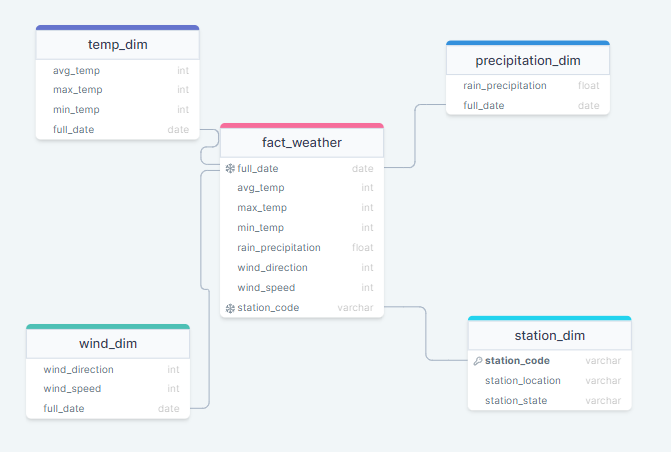

# Dataset summary.

### Link to the data set: https://corgis-edu.github.io/corgis/csv/weather/
### To the extent of my Data Quality analysis, the provided data set was generally very clean. However, regarding creating a star schema - it deemed to be more challenging than expected since the data was not very broad.

# Overall summary:

### Reflecting back on the task I would have chosen a broader dataset to be able to create a more reasonable fact-dimension table. Also in my future use of Snowflake, I plan to dig deeper into it's features and functionality since this time around I only had a chance to see it at face-value.